In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import os
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX
import jax
import jax.numpy as jnp
import numpy as np

In [3]:
# Taking draws from a normal distribution
seed = 42
x_dist = pm.Normal.dist(shape=(100, 3))
x_data = pm.draw(x_dist, random_seed=seed)

In [4]:
# Define coordinate values for all dimensions of the data
coords={
 "trial": range(100),
 "features": ["sunlight hours", "water amount", "soil nitrogen"],
}

# Define generative model
with pm.Model(coords=coords) as generative_model:
   x = pm.Data("x", x_data, dims=["trial", "features"])

   # Model parameters
   betas = pm.Normal("betas", dims="features")
   sigma = pm.HalfNormal("sigma")

   # Linear model
   mu = pm.Deterministic('mu', x @ betas)  # MMcD: make this into a pm.Deterministic for plotting

   # Likelihood
   # Assuming we measure deviation of each plant from baseline
   plant_growth = pm.Normal("plant growth", mu, sigma, dims="trial")

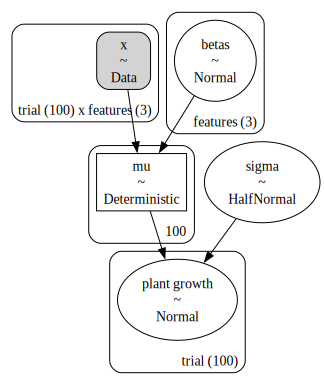

In [5]:
pm.model_to_graphviz(generative_model)

In [6]:
# Generating data from model by fixing parameters
fixed_parameters = {
 "betas": [5, 20, 2],
 "sigma": 0.5,
}
with pm.do(generative_model, fixed_parameters) as synthetic_model:
   idata = pm.sample_prior_predictive(random_seed=seed) # Sample from prior predictive distribution.
   synthetic_mu = idata.prior['mu'].sel(draw=0, chain=0) # MMcD: add this for plotting
   synthetic_y = idata.prior["plant growth"].sel(draw=0, chain=0)


Sampling: [plant growth]


<Axes: xlabel='mu', ylabel='plant growth'>

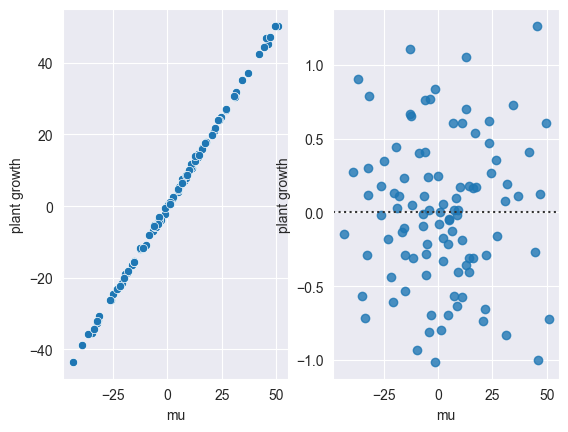

In [7]:
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(x=synthetic_mu, y=synthetic_y, ax=axs[0])
sns.residplot(x=synthetic_mu, y=synthetic_y, ax=axs[1])

In [8]:

# Infer parameters conditioned on observed data
with pm.observe(generative_model, {"plant growth": synthetic_y}) as inference_model:
   idata = pm.sample(1000, random_seed=seed, nuts_sampler='blackjax', chains=n_devices, show_progress=False)

   summary = pm.stats.summary(idata, var_names=["betas", "sigma"])
   print(summary)

/Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(


Running window adaptation


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
betas[sunlight hours]   4.973  0.054   4.869    5.073        0.0      0.0   
betas[water amount]    19.963  0.050  19.868   20.057        0.0      0.0   
betas[soil nitrogen]    1.996  0.056   1.890    2.102        0.0      0.0   
sigma                   0.512  0.038   0.442    0.582        0.0      0.0   

                       ess_bulk  ess_tail  r_hat  
betas[sunlight hours]   15975.0   11570.0    1.0  
betas[water amount]     17103.0   12012.0    1.0  
betas[soil nitrogen]    16503.0   12725.0    1.0  
sigma                   15966.0   12240.0    1.0  


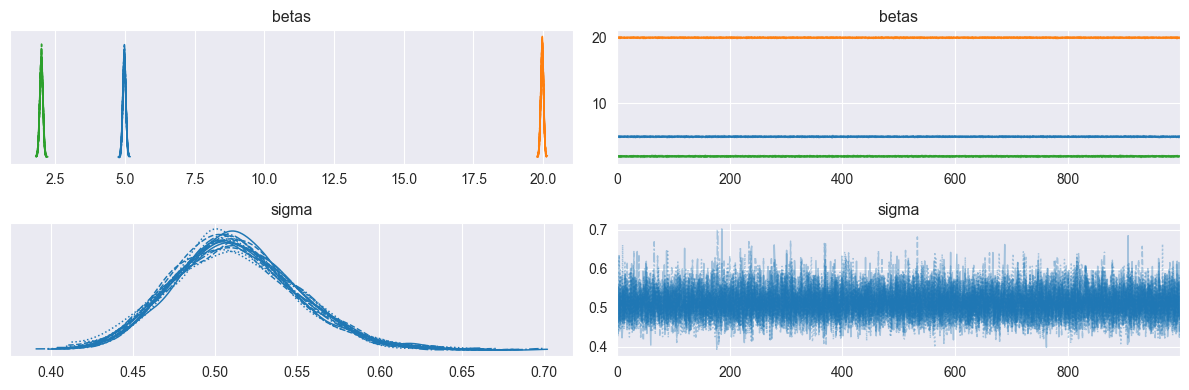

In [9]:
az.plot_trace(idata, var_names=["~mu"])
plt.tight_layout()